https://towardsdatascience.com/a-complete-guide-to-recommender-system-tutorial-with-sklearn-surprise-keras-recommender-5e52e8ceace1
# Recommendation System 
## 1. Popülerliğe Göre Öneri  
Bu yöntem ile genel popülasyonun yönelimine göre öneri yapabiliriz. "IMBD en çok oy alan filmler" listesi buna örnek olarak gösterilerbilir.  
Bu öneriler hakkında bilgimiz olmayan yeni bir kullanıcıya öneri yapmak için kullanılabilir. Buradaki genel problem tüm kullanıcılara aynı öneri yapılır.  
## 2. İçerik Bazlı Öneri 
Kullanıcıya daha iyi önerilerde bulunmak için içerik bazlı öneride yapılabilir. Burada ürünlerin/filmlerin bir birlerine benzerliğinden faydalanarak birini beğenen kullanıcıya diğerlerini önerebiliriz. Buradaki sorun ise kullancıya yeni şeyler önermek yerine daha önceki davranışlarından yararlanarak her zaman benzer ürünleri önermek olacaktır.  
## 3. Collabrative Filtering
Hem kullanıcı hemde kullanıcının etkileşime girdiği ürünler hakkında bilgimiz olduğu durumda kullanırız. User-Item Interaction matrix den yararlanarak önerilerde bulunuruz.  
Kullancııların explixit veya implicit oylamarından yararlanarak User-Item Interaction Matrix oluşturulur.  
* Explicitly -> Kullanıcıya oy verdirerek (Ürene kaç yıldız verdi? - Filmi beğendin mi?)
* Implicitly -> Kullanıcının davranışlarından (Bir web sitesindeki bir linke tıklaması yada bir reklama tıklaması)

### 3.1 User-Based Collabrative Filtering
Bu yöntem ile öneriler kullanıcıların birbirleri ile benzerliğine göre öneri yapılır. Kullanıcıların benzerliğini user-item interraction matrix inden alırız. Tüm kullanıcılar etkileşime girdikleri ürünlere göre öneri alırlar.  
Burada yaşanacak sorun ise herhangi bir user için önceki bilgilerine ihtiyacımız var. Çünkü öneri yapabilmek için kullanıcıyı diğer kullanıcılara benzetecek veri elimizde olmayacak. Bu probleme Cold-Start problemi denir. Bu sorunu çözmek için kullanıcıya Populer önerileri sunarız ve bunlardan hangilerini beğendiğine göre genel bir veri oluşturabiliriz. 

### 3.2 Item-Based Collabrative Filtering 
Kullanıcıların benzerlikleri yerine ürünlerin benzerliklerinden faydalanarak da öneriler sunabiliriz. Herhangi bir userın beğendiği birüründen yararlanarak ona benzeyen diğer ürünleri kullanıcıya önerebiliriz. Her yeni eklenen ürün için ön bir bilgiye ihtiyacımız olacak. Bunu çözmek içerik bazlı öneri ile gerekli datayı toplamaya çalışırız. 

## 4. Hybrid 
Her bir metodun başarılı olduğu özellikleri vardır. Bunları birlikte kullanarak daha başarılı öneri modelleri oluşturabiliriz. İçerik bazlı öneri ve item based collabrative filtering ile daha başarılı önerilerde bulunuruz. Örn: Filmin türü ve filmin diğer filmlere olan benzerliği ile kullanıcıya daha başarılı öneriler sunulabilir. 


Bu yazıda kullanacağımız verileri kaggledan movilen veri setinden indirip sizde uygulayabilirsiniz. Ben burada movilen datasından alınmış ufak bir sample üzerinden ilerleyeceğim. Benim kullandığım veriyide github linkinden indirebilirsiniz.  
Orginal veriden bir örneklem alındığı için orginal imdb datasından daha farklı sonuçlar görebiliriz. 

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.metrics.pairwise import cosine_similarity

plt.style.use('fivethirtyeight')

ratings_df = pd.read_csv("ml-latest-small/ratings.csv")
movies_df = pd.read_csv("ml-latest-small/movies.csv")

C:\Users\bagat\anaconda3\envs\tensorflow\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\bagat\anaconda3\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\bagat\anaconda3\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


## Implementation
Bu kısımda yukarıda bahsettiğimiz başlıkları kodlar üzerinde inceleyelim. Öncelikle verileri pandas kütüphanesinden yararlanarak okuyalım. 

## 1. Popular Based (Popülerliğe göre)
Tüm kullanıların oylamalarından yararlanarak en yüksek puanı alan ürünleri önererek implemente edebiliriz. Direkt olarak ortalama puan yerine IMDB ninde kullandığı weighted rating yöntemini kullanalım.  

* R: ortalama puan 
* v: verilen oy sayısı
* m: listelenmek için gerekli oy sayısı
* C: Tüm veri setindeki ortalama puan
WR = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C  
Yukarıdaki formülü kod üzerinde görelim.

Aşağıdaki gibi weighted_rating ve get_popular_movies adında iki fonksiyon oluşturalım. weighted_rating metodu ile elimizdeki datadaki filmler için weighted_rating değerlerini hesaplayıp ilgili sutuna yazacağız. get_popular_movies ilede weighted_rating bilgisini hesapladığımız filmleri alacağız. 

In [3]:
def weighted_rating(v,m,R,C):
    '''
    R = average for the movie (mean) = (Rating)
    v = number of votes for the movie = (votes)
    m = minimum votes required to be listed - percentile 70
    C = average rating for whole dataset 

    '''
    return ( (v / (v + m)) * R) + ( (m / (v + m)) * C )

def get_popular_movies(ratings_df,movies_df):
    
    # öncelikle groupby kullanarak filmlere kaç kullanıcı oy vermiş ve her film ortalama kaç puan almış hesaplayalım.
    vote_count_df = ratings_df.groupby("movieId",as_index=False).agg({"userId":"count","rating":"mean"})
    # column isimlerini daha anlaşılır olması için değiştirdik. 
    vote_count_df.columns = ["movieId","vote_count","avg_rating"]
    
    # weighted_rating hesaplamak için gerekli olan değerleri aşağıdaki gibi hesaplayalım. 
    C = np.mean(vote_count_df["avg_rating"])
    m = np.percentile(vote_count_df["vote_count"],70)
    vote_count_df = vote_count_df[vote_count_df["vote_count"]>m]
    v = vote_count_df["vote_count"]
    R = vote_count_df["avg_rating"]
    
    # weighted_rating metodu ile ilgili sutunu ekleyelim. 
    vote_count_df["weighted_rating"] = weighted_rating(v,m,R,C)
    # movies_df ile vote_count_df merge edelim. Filmlerin adı movies dataframei içerisinde. 
    vote_count_df = vote_count_df.merge(movies_df,on=["movieId"],how="left")
    # istediğimiz sutunlar ile yeni bir df oluşturalım. 
    popular_movies = vote_count_df.loc[:,["movieId","title","genres","vote_count","avg_rating","weighted_rating",]]
    return popular_movies

In [4]:
popular_movies = get_popular_movies(ratings_df=ratings_df,movies_df=movies_df)
popular_movies.head()

,movieId,title,genres,vote_count,avg_rating,weighted_rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,247,3.872470,3.856474
1,2,Jumanji (1995),Adventure|Children|Fantasy,107,3.401869,3.395126
2,3,Grumpier Old Men (1995),Comedy|Romance,59,3.161017,3.174915
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,13,2.384615,2.702219
4,5,Father of the Bride Part II (1995),Comedy,56,3.267857,3.270546


Aşağıdaki en yüksek puan olan 10 popüler filmi görebilirsiniz. Bunları bir grafik ilede gösterebiliriz. 

In [5]:
top_10_movies = popular_movies.sort_values(by="weighted_rating",ascending=False)[:10]
top_10_movies

,movieId,title,genres,vote_count,avg_rating,weighted_rating
184,318,"Shawshank Redemption, The (1994)",Crime|Drama,311,4.487138,4.460831
413,858,"Godfather, The (1972)",Crime|Drama,200,4.487500,4.447074
41,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,201,4.370647,4.334348
599,1221,"Godfather: Part II, The (1974)",Crime|Drama,135,4.385185,4.331298
470,969,"African Queen, The (1951)",Adventure|Comedy|Romance|War,50,4.420000,4.281480
433,913,"Maltese Falcon, The (1941)",Film-Noir|Mystery,62,4.387097,4.276006
299,527,Schindler's List (1993),Drama|War,244,4.303279,4.275077
445,926,All About Eve (1950),Drama,38,4.434211,4.256542
627,1252,Chinatown (1974),Crime|Film-Noir|Mystery|Thriller,76,4.335526,4.247523
424,904,Rear Window (1954),Mystery|Thriller,92,4.315217,4.242873


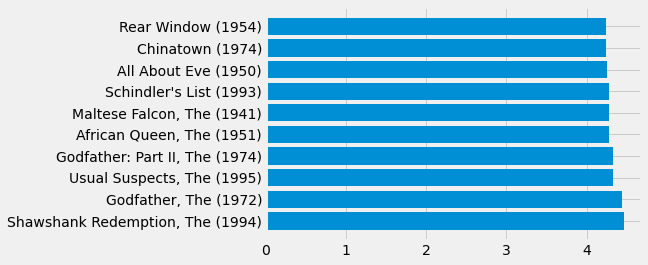

In [6]:
plt.barh(top_10_movies["title"],top_10_movies["weighted_rating"])
plt.show()

## 2. İçerik Bazlı Öneri (Content Based)
İçerik bazlı öneride Tür(genre) bilgilerinden yararlanarak öneri yapabiliriz.  Elimizdeki verisetin aşağıdakı gibi kullanıcıların oyladığı filmleri çekelim. 

In [56]:
rated_movies = movies_df.loc[movies_df["movieId"].isin(ratings_df["movieId"])].copy()
rated_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [230]:
# rated_movies df bulunan genres sutunundaki verileri "|" ile ayırdık. expand=True ile içerisindeki elementleri 
# ayrı bir sutuna çevirdik. 
genres = rated_movies["genres"].str.split("|",expand=True)
genres

,0,1,2,3,4,5,6,7,8,9
0,Adventure,Animation,Children,Comedy,Fantasy,None,None,None,None,None
1,Adventure,Children,Fantasy,None,None,None,None,None,None,None
2,Comedy,Romance,None,None,None,None,None,None,None,None
3,Comedy,Drama,Romance,None,None,None,None,None,None,None
4,Comedy,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
9117,Drama,None,None,None,None,None,None,None,None,None
9118,Drama,None,None,None,None,None,None,None,None,None
9119,Romance,Thriller,None,None,None,None,None,None,None,None
9120,Adventure,Drama,Romance,None,None,None,None,None,None,None


In [59]:
# unique türleri bulaım
all_genres = set()
for column in genres.columns:
    genre = genres[column].str.lower().str.strip().unique()
    all_genres.update(genre)
all_genres.remove(None)

In [236]:
## item-genre matrix oluşturalım 
movie_genre_mat = rated_movies[["movieId","genres"]].copy()
movie_genre_mat["genres"] = movie_genre_mat["genres"].str.lower().str.strip()

In [237]:
for genre in all_genres:
    movie_genre_mat[genre] = np.where(movie_genre_mat["genres"].str.contains(genre),1,0)
movie_genre_mat = movie_genre_mat.drop("genres",axis=1)
movie_genre_mat = movie_genre_mat.set_index("movieId")

C:\Users\bagat\anaconda3\envs\tensorflow\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [61]:
corr_mat = cosine_similarity(movie_genre_mat)

In [243]:
corr_mat.shape

(9066, 9066)

In [174]:

ind2id = {ind : rated_movies.iloc[ind]["movieId"] for ind in range(len(rated_movies))}
ind2name = {ind : rated_movies.iloc[ind]["title"] for ind in range(len(rated_movies))}
id2ind = {v:k for k,v in ind2id.items()}

Aşağıda izlenilen filmin index bilgisi alınır. Bu index bilgisi ile corr_mat içerisinde zaten tüm filmlerin birbirleri ile tür bakımıdan benzerliğine göre 0 ile 1 arasında bir değer bulunuyor. Bir birlerini benzeyen filmler için bu değer 1'e yakınken benzemeyen filmlerde bu değer 0'a yakındır. Seçilen indexli filmin korelasyon matirisi üzerinde diğer filmler ile benzerliğini bulmak için aldığımız değerleri arg sort ile sıralarız. Daha sonra kaç film döndürmek istiyorsak bunu döndürebiliriz. Burada bize index bilgisi dönecektir. Bu indexlerden ind2name ile isim bilgisini alabiliriz. 

In [228]:
def get_top_n_recommendations(ind,top_n):
    # argsort ile değere göre sıralayıp indexlerini tutuyoruz. Küçükten büyüğe sıralanıp son 10 tanesi bizim için 
    # benzer filmlerdir. Bu 10 filmi tersten sıralayarak en yüksek benzerliği olanı listenin en başına alırız. 
    top_n_movies = corr_mat[ind,:].argsort()[-top_n-1:-1][::-1] 
    top_n_movies = [ind2name[m] for m in top_n_movies] 
    
    print(f"Movie Name: {ind2name[INDEX]}")
    print(f"-----------------")
    print("Recommended Movies: ")
    print("-------------------")
    
    for i in top_n_movies:
        print(i)
    return top_n_movies

In [229]:
INDEX = 0
TOP_N = 10

top_n_movies = get_top_n_recommendations(INDEX,TOP_N)

Movie Name: Toy Story (1995)
-----------------
Recommended Movies: 
-------------------
Toy Story 2 (1999)
Boxtrolls, The (2014)
Turbo (2013)
Asterix and the Vikings (Astérix et les Vikings) (2006)
Tale of Despereaux, The (2008)
Shrek the Third (2007)
Antz (1998)
The Good Dinosaur (2015)
Monsters, Inc. (2001)
Adventures of Rocky and Bullwinkle, The (2000)


In [31]:
import pandas as pd 

ratings = pd.read_csv("ml-latest-small/ratings.csv")
movies = pd.read_csv("ml-latest-small/movies.csv")
tags = pd.read_csv("ml-latest-small/tag.csv")

In [32]:
ratings.head(2)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179


In [33]:
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [34]:
tags.head(2)

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18


In [35]:
movies["genres"] = movies["genres"].str.replace("|"," ")

C:\Users\bagat\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [36]:
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy


In [37]:
ratings_f = ratings.groupby("userId").filter(lambda x:len(x)>=50)

filtered_movie_list = ratings_f["movieId"].unique()

In [38]:
len(ratings_f["movieId"].unique()) / len(ratings["movieId"].unique())

0.9912861239797044

In [39]:
len(ratings_f["userId"].unique()) / len(ratings["userId"].unique())

0.6363636363636364

In [40]:
movies = movies[movies["movieId"].isin(filtered_movie_list)]

In [41]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [42]:
title2id = dict(zip(movies.title,movies.movieId))

In [43]:
ratings_f.drop(["timestamp"],axis=1,inplace=True)
tags.drop(["timestamp"],axis=1,inplace=True)

In [50]:
mixed_df = pd.merge(movies,tags,on="movieId",how="left")
mixed_df.head()

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1644.0,Watched
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,computer animation
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,Disney animated feature
3,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,Pixar animation
4,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,TÃ©a Leoni does not star in this movie


In [54]:
mixed_df.fillna("",inplace=True)
mixed_df = pd.DataFrame(mixed_df.groupby("movieId")["tag"].apply(lambda x: " ".join(x)))

In [55]:
final_df = pd.merge(movies,mixed_df,on="movieId",how="left")
final_df.head()

,movieId,title,genres,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Watched computer animation Disney animated fea...
1,2,Jumanji (1995),Adventure Children Fantasy,time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),Comedy Romance,old people that is actually funny sequel fever...
3,4,Waiting to Exhale (1995),Comedy Drama Romance,chick flick revenge characters chick flick cha...
4,5,Father of the Bride Part II (1995),Comedy,Diane Keaton family sequel Steve Martin weddin...


In [59]:
final_df["metadata"] = final_df[["genres","tag"]].apply(lambda x:" ".join(x),axis=1)
final_df.head(3)

,movieId,title,genres,tag,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Watched computer animation Disney animated fea...,Adventure Animation Children Comedy Fantasy Wa...
1,2,Jumanji (1995),Adventure Children Fantasy,time travel adapted from:book board game child...,Adventure Children Fantasy time travel adapted...
2,3,Grumpier Old Men (1995),Comedy Romance,old people that is actually funny sequel fever...,Comedy Romance old people that is actually fun...


In [66]:

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(stop_words="english")
tfidf_mat = tfidf_vec.fit_transform(final_df["metadata"])
tfidf_df = pd.DataFrame(tfidf_mat.toarray(),index=final_df.index.tolist())
tfidf_df.shape

(8987, 19411)

In [67]:
tfidf_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,19401,19402,19403,19404,19405,19406,19407,19408,19409,19410
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


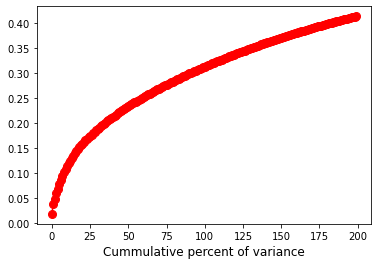

In [71]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt 
tsvd = TruncatedSVD(n_components=200)
latent_mat = tsvd.fit_transform(tfidf_df)
explained = tsvd.explained_variance_ratio_.cumsum()
plt.plot(explained,".-",ms=16,color="red")
plt.xlabel("Singular value components",fontsize=12)
plt.xlabel("Cummulative percent of variance",fontsize=12)
plt.show()

In [75]:
# latent_matrix_1_df adında df oluştur latent_matrix ve film isimleri ile
latent_matrix_1_df = pd.DataFrame(latent_mat,index=final_df.title.tolist())

In [77]:
latent_matrix_1_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),0.076845,-0.060659,0.098909,-0.118228,-0.216102,0.007631,-0.093758,-0.065304,0.022154,-0.335704,...,0.022386,-0.013617,0.008207,-0.036623,0.021154,-0.071822,-0.009284,-0.101470,0.033849,-0.095816
Jumanji (1995),0.038280,-0.009331,0.083656,-0.040777,-0.106921,0.023960,-0.072111,0.000487,0.022619,-0.059965,...,-0.005436,-0.005639,-0.003200,0.031824,0.009996,-0.021679,-0.038296,-0.013387,0.008167,0.033445
Grumpier Old Men (1995),0.072297,-0.058126,0.001761,0.007001,-0.006754,0.003218,-0.008483,0.032913,-0.007300,0.003895,...,-0.006024,-0.001814,0.006081,-0.008189,0.005632,-0.013458,0.002807,-0.000155,-0.002020,0.005237
Waiting to Exhale (1995),0.185820,-0.018812,-0.036923,0.030814,-0.016345,0.008030,-0.041983,0.114317,-0.062890,0.003348,...,-0.014677,-0.030079,-0.059591,0.030358,-0.034281,0.026185,-0.018522,0.038657,-0.005448,-0.001580
Father of the Bride Part II (1995),0.089917,-0.077456,0.024209,-0.001731,-0.030007,0.014236,-0.005218,-0.003734,0.033311,-0.014290,...,0.031360,0.024792,-0.000419,0.015323,0.034883,-0.002842,-0.016576,-0.009607,-0.017276,0.034937


In [82]:
# collaborative filtering index movieid column userid datarating olacak şekilde pivot table oluştur
# TruncatedSVD ile boyut küçült explained variance bas

ratings_f2 = ratings_f.pivot_table(index="movieId",columns="userId",values="rating").fillna(0)

In [83]:
ratings_f2.head()

userId,2,3,4,5,7,8,12,13,15,17,...,655,656,658,659,660,662,664,665,667,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,2.0,0.0,...,0.0,0.0,0.0,0.0,2.5,0.0,3.5,0.0,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,4.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0
3,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0


In [90]:
tsvd = TruncatedSVD(n_components=200)
latent_mat_2 = tsvd.fit_transform(ratings_f2)
latent_matrix_2_df = pd.DataFrame(latent_mat_2,index=final_df.title.tolist())

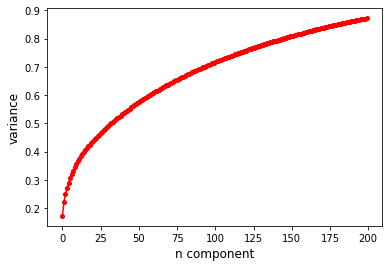

In [91]:
explained = tsvd.explained_variance_ratio_.cumsum()
plt.plot(explained,".-",ms=8,color="red")
plt.xlabel("n component",fontsize=12)
plt.ylabel("variance",fontsize=12)
plt.show()

In [100]:
# Toy Story (1995) a_1 ve a_2 olarak cont , collab vektörlerini al cos_sim hesapla hybrid hesapla
# bunu bir dict ile df e bas benzerliğe göre sort et
# ilk 10 taneyi bas.
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
a_1 = np.array(latent_matrix_1_df.loc["Toy Story (1995)"]).reshape(1,-1)
a_2 = np.array(latent_matrix_2_df.loc["Toy Story (1995)"]).reshape(1,-1)

score_1 = cosine_similarity(latent_matrix_1_df,a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df,a_2).reshape(-1)

hybrid = ((score_1+score_2)/2.0)

dictDf = {"content":score_1,"collaborative":score_2,"hybrid":hybrid}

similar = pd.DataFrame(dictDf,index=final_df.title)

similar.sort_values("hybrid",ascending=False,inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
title,,,
Toy Story 2 (1999),0.969809,0.724329,0.847069
"Bug's Life, A (1998)",0.918375,0.632862,0.775619
"Monsters, Inc. (2001)",0.904978,0.626739,0.765859
Finding Nemo (2003),0.890032,0.589151,0.739591
"Incredibles, The (2004)",0.815685,0.598820,0.707253
Ice Age (2002),0.890636,0.424750,0.657693
Toy Story 3 (2010),0.873718,0.436770,0.655244
Ratatouille (2007),0.909518,0.358339,0.633928
Up (2009),0.790379,0.415120,0.602749
